In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from collections import OrderedDict
import matplotlib.pyplot as plt

## Data from the audio test

In [2]:
data = pd.read_excel("data.xlsx", usecols = [0,1,2,3,4])
data.head()

,ID,Instrument,timbre,heard_pitch,answered_pitch
0,1,piano,sin,c4,c
1,1,piano,sin,g#5,a
2,1,piano,sin,f4,f
3,1,piano,sin,a5,b
4,1,piano,sin,d#3,e


In [3]:
data.dropna()
#data = data[~(str(data['heard_pitch']) == 'nan') & ~(str(data['heard_pitch']) == 'NaN')]

# remove the octave annotations
data['heard_pitch'] = data['heard_pitch'].str.replace('[0-9 ]+', "")

In [4]:
# Convert the pitch heights into numbers to compute the difference 

pitch_dict = {
    #this dict was wrong bc there was a disctance of 12 btw the C and B...
   # 'c':1, 'c#':2, 'db':2, 'd':3, 'd#':4, 'eb':4, 'e':5, 'fb':5, 'f':6, 'e#':6, 'f#':7, 'gb':7, 'g':8, 'g#':9, 'ab':9, 'a':10, 'a#':11, 'bb':11, 'b':12, 'cb':12, 'b#':1}
    # this dict again made the computed dist too big
  #  'c':0, 'c#':1, 'db':1, 'd':2, 'd#':3, 'eb':3, 'e':4, 'fb':4, 'f':5, 'e#':5, 'f#':6, 'gb':6, 'g':-5, 'g#':-4, 'ab':-4, 'a':-3, 'a#':-2, 'bb':-2, 'b':-1, 'cb':-1, 'b#':0}
    # this dict is right but has no direction (answer above or under the right pitch)
      'c':0, 'c#':1, 'db':1, 'd':2, 'd#':3, 'eb':3, 'e':4, 'fb':4, 'f':5, 'e#':5, 'f#':6, 'gb':6, 'g':5, 'g#':4, 'ab':4, 'a':3, 'a#':2, 'bb':2, 'b':1, 'cb':1, 'b#':0}

def pitch_to_int(x):
    if x in pitch_dict.keys():
        return pitch_dict[x]
    else:
        #print(x)
        return np.NaN

dataT = data.copy()
dataT['heard_pitch'] = dataT['heard_pitch'].apply(lambda x : pitch_to_int(x))
dataT['answered_pitch'] = dataT['answered_pitch'].apply(lambda x : pitch_to_int(x))



#dataT[dataT['heard_pitch'] == np.NaN]

In [37]:
# compute the diff and abs diff

dataT['diff'] = dataT['heard_pitch'] - dataT['answered_pitch']
dataT['abs_diff'] = abs(dataT['heard_pitch'] - dataT['answered_pitch'])
dataT.head()


,ID,Instrument,timbre,heard_pitch,answered_pitch,diff,abs_diff
0,1,piano,sin,0.0,0.0,0.0,0.0
1,1,piano,sin,4.0,3.0,1.0,1.0
2,1,piano,sin,5.0,5.0,0.0,0.0
3,1,piano,sin,3.0,1.0,2.0,2.0
4,1,piano,sin,3.0,4.0,-1.0,1.0


### Statistics

In [6]:
# mean global error
dataT['abs_diff'].mean()
dataT['diff'].mean()
#dataT['abs_diff'].groupby('ID').describe()
#dataT['abs_diff'].groupby('Instrument').describe()
dataT['diff'].describe()

count    1254.000000
mean        0.058214
std         2.084938
min        -6.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: diff, dtype: float64

## Data from the form 

In [7]:
form_data = pd.read_excel("form.xlsx", sheet_name = 'formated')
form_data = form_data[0:45]
form_data = form_data.dropna(how = 'all')
form_data.shape
form_data.head()


,id,instr_principal,instr_sec,age,estimated_cap,age_ap,family_ap,age_music_studies,rate_theory,rate_technique,...,band,ensemble,orchestra,band_other,scores,chords + tabs,improvising,hearing,by heart,other.1
0,1,piano,NaN,18,AP,8.0,0.0,4,8.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,saxophone,NaN,18,RP,NaN,0.0,6,7.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,trombone,NaN,19,RP,NaN,0.0,4,6.0,9.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4,trombone,piano,26,RP,NaN,0.0,6,9.0,7.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,saxophone,NaN,25,RP,NaN,0.0,6,7.0,6.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# number of different instruments
form_data.instr_principal.value_counts()

guitare        6
piano          5
trompette      4
violon         4
alto           3
trombone       3
violoncelle    3
saxophone      3
batterie       2
hautbois       1
clarinette     1
cor            1
Name: instr_principal, dtype: int64

In [9]:
# group the instr per class : wind, percussion, string
# -> wind, tuned / untuned percussions, fret / fretless strings ?

instr_dict = { 'piano' : 'percussion', 'batterie' : 'percussion',  
              'violon' : 'string', 'alto' : 'string', 'violoncelle' : 'string', 'guitare' : 'string',
              'contrebasse':'string', 'basse':'string',
              'trompette' : 'wind', 'trombone' : 'wind', 'saxophone' : 'wind', 'hautbois' : 'wind', 
              'clarinette' : 'wind', 'cor' : 'wind', 'flute':'wind', 'chant':'wind'
} # j'ai mis 'chant' dans 'wind'...

def instr_to_class(x):
    if x in instr_dict.keys():
        return instr_dict[x]
    else:
        #print(x)
        return np.NaN

formT = form_data.copy()
formT['instr_class'] = formT['instr_principal'].apply(lambda x : instr_to_class(x))
formT['instr_sec_class'] = formT['instr_sec'].apply(lambda x : instr_to_class(x))

formT.instr_class.value_counts()


string        16
wind          13
percussion     7
Name: instr_class, dtype: int64

In [10]:
# quantifié = 1, nonquantifié = 0 /!\ on ne sait pas dans quelle catégorie vont la batterie et la trompette
quant_dict = { 'piano' : 1, 'batterie' : 0,  
              'violon' : 0, 'alto' : 0, 'violoncelle' : 0, 'guitare' : 1,
              'contrebasse':0, 'basse':1,
              'trompette' : 1, 'trombone' : 0, 'saxophone' : 1, 'hautbois' : 1, 
              'clarinette' : 1, 'cor' : 1, 'flute':1, 'chant':0
}

def instr_to_quant(x):
    if x in quant_dict.keys():
        return quant_dict[x]
    else:
        #print(x)
        return np.NaN

formT['instr_quant'] = formT['instr_principal'].apply(lambda x : instr_to_quant(x))
formT['instr_sec_quant'] = formT['instr_sec'].apply(lambda x : instr_to_quant(x))



## Merged dataset

In [11]:
dataT.columns

Index([            u'ID',     u'Instrument',         u'timbre',
          u'heard_pitch', u'answered_pitch',           u'diff',
             u'abs_diff'],
      dtype='object')

In [12]:
merged_df = dataT.merge(formT, how = 'outer', left_on='ID', right_on='id')
merged_df.head()
merged_df = merged_df.drop(columns={'id', 'Instrument'})


In [13]:
writer = pd.ExcelWriter('merged_df.xlsx', engine='xlsxwriter')
merged_df.to_excel(writer, sheet_name='Sheet1')
writer.save()

merged_df.head()

,ID,timbre,heard_pitch,answered_pitch,diff,abs_diff,instr_principal,instr_sec,age,estimated_cap,...,scores,chords + tabs,improvising,hearing,by heart,other.1,instr_class,instr_sec_class,instr_quant,instr_sec_quant
0,1,sin,0.0,0.0,0.0,0.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
1,1,sin,4.0,3.0,1.0,1.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
2,1,sin,5.0,5.0,0.0,0.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
3,1,sin,3.0,1.0,2.0,2.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
4,1,sin,3.0,4.0,-1.0,1.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN


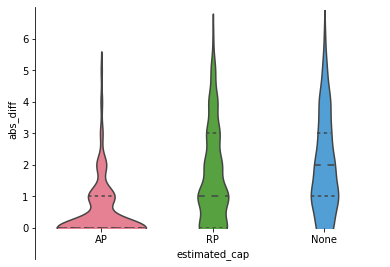

In [103]:
sns.violinplot(x = 'estimated_cap', y = 'abs_diff', data=merged_df, palette ='husl', inner = 'quart')
sns.despine(offset=10, trim=True, bottom = True)
plt.ylim(0,6.9)

plt.savefig('fig1.png', dpi = 400)

## Grouped Boxplots
y axis = frequency, x axis = error (directionnal -> not absolute), box plots per instrument class (3 values)

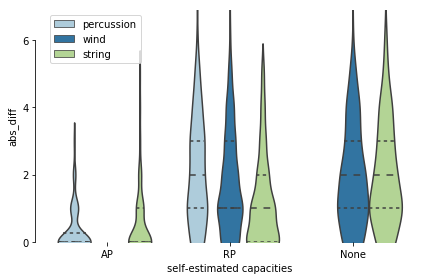

In [104]:
sns.violinplot(x = 'estimated_cap', y = 'abs_diff', hue='instr_class', data=merged_df, palette = 'Paired', inner = 'quart')
sns.despine(offset=10, trim=True, bottom = True, right=True)

#legend out of the figure
plt.legend(loc='upper left')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.xlabel('self-estimated capacities')
plt.ylim(0,6.9)


plt.tight_layout()
plt.savefig('fig2.png', dpi = 400)

These boxplots show the absolute difference in the answers given by the participants, grouped per their estimated capacities (given by themselves), and separated by instrument class.

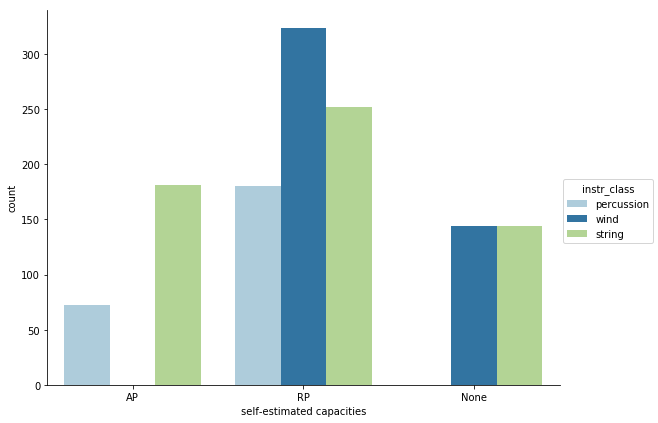

In [16]:
# estimated cap per instr class
sns.factorplot(x='estimated_cap', hue='instr_class', data=merged_df, kind="count",
                   palette="Paired", size=6, aspect=1.3)
plt.xlabel('self-estimated capacities')
plt.savefig('fig3.png', dpi = 400)

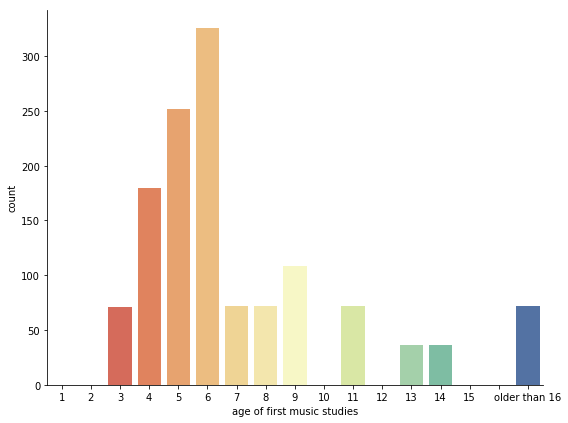

In [17]:
# histogram of age at which participants began their musical studies
sns.factorplot(x='age_music_studies', data = merged_df, kind = 'count', order=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,' ','older than 16'],size=6, aspect=1.3, palette = 'Spectral')
plt.xlabel('age of first music studies')
plt.savefig('fig4.png', dpi = 400)

"\nsns.factorplot(x='abs_diff', data = merged_df, kind = 'count',size=6, aspect=1, palette = 'Paired')\nplt.xlabel('difference')\nplt.savefig('fig5.png', dpi = 400)\n"

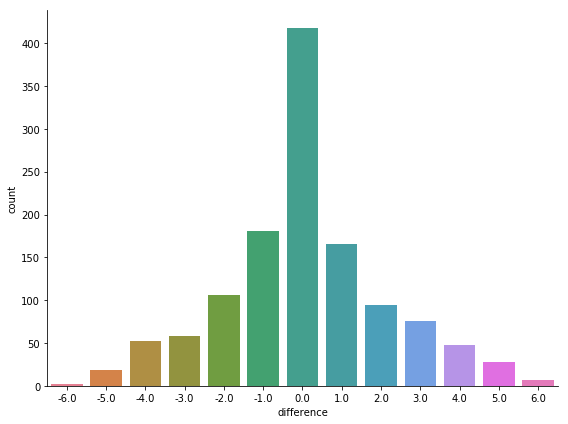

In [89]:
sns.factorplot(x='diff', data = merged_df, kind = 'count',size=6, aspect=1.3, palette = 'husl')
plt.xlabel('difference')
plt.savefig('fig5.png', dpi = 400)

"""
sns.factorplot(x='abs_diff', data = merged_df, kind = 'count',size=6, aspect=1, palette = 'Paired')
plt.xlabel('difference')
plt.savefig('fig5.png', dpi = 400)
"""

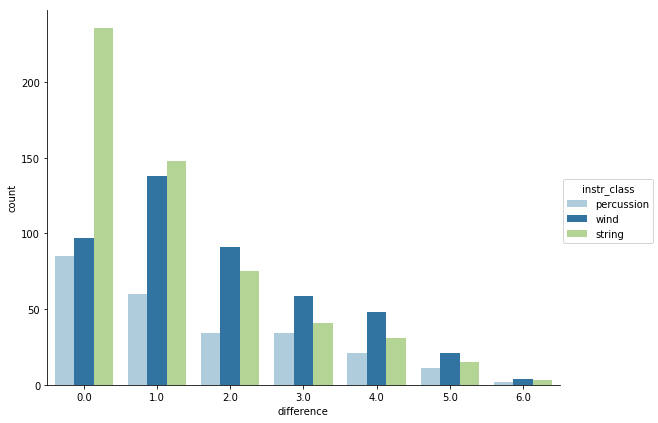

In [90]:
sns.factorplot(x = 'abs_diff', hue = 'instr_class', data = merged_df, kind = 'count',size=6, aspect=1.3, palette = 'Paired')
plt.xlabel('difference')
plt.savefig('fig6.png', dpi = 400)



In [159]:
# average difference
merged_df.groupby('instr_class')['abs_diff'].describe()


,count,mean,std,min,25%,50%,75%,max
instr_class,,,,,,,,
percussion,247.0,1.542510,1.558224,0.0,0.0,1.0,3.0,6.0
string,549.0,1.162113,1.387228,0.0,0.0,1.0,2.0,6.0
wind,458.0,1.786026,1.485915,0.0,1.0,1.0,3.0,6.0


In [21]:
merged_df.instr_class.value_counts() / 36


string        16.027778
wind          13.000000
percussion     7.000000
Name: instr_class, dtype: float64

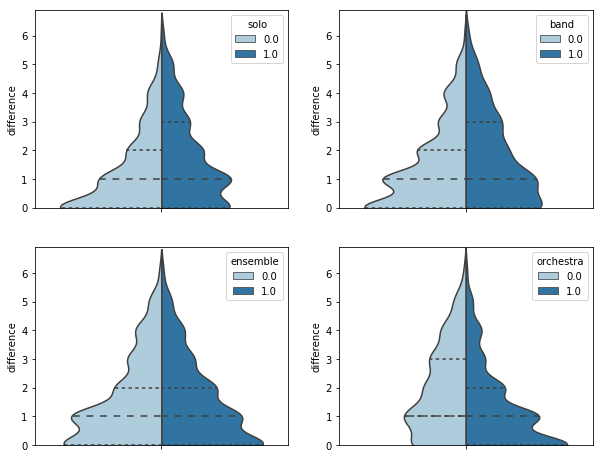

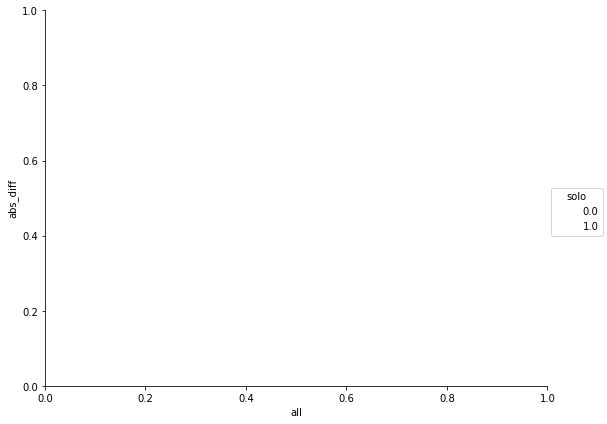

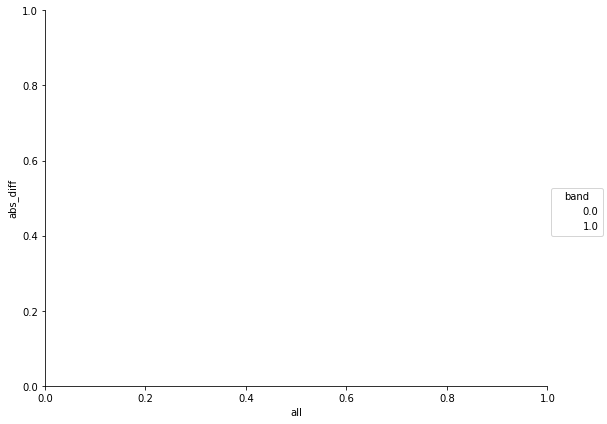

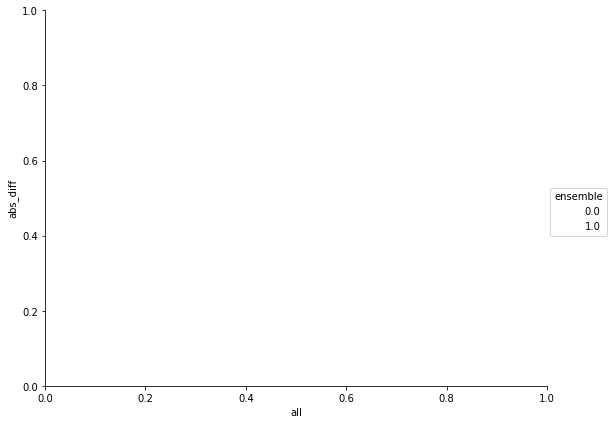

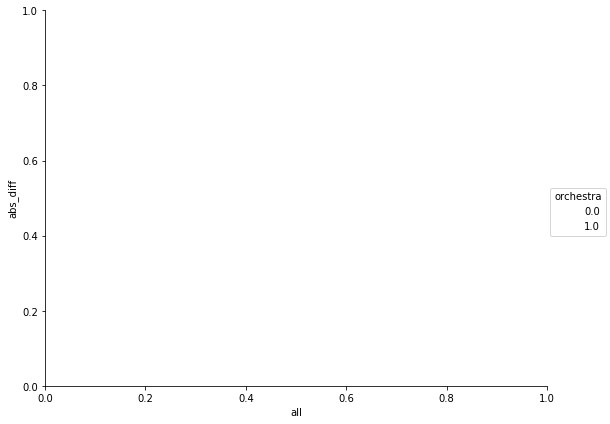

In [99]:
#sns.violinplot(x=['solo', 'band'], y='diff', hue = 'family_ap', data = merged_df, split = True)
fig7 = plt.figure(figsize=(10,8))
ax1 = fig7.add_subplot(221)
ax2 = fig7.add_subplot(222)
ax3 = fig7.add_subplot(223)
ax4 = fig7.add_subplot(224)

merged_df["all"] = ""
sns.factorplot(x = 'all', y ='abs_diff', hue = 'solo', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax1, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'band', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax2, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'ensemble', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax3, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'orchestra', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax4, inner = 'quart')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_ylabel('difference')
ax2.set_ylabel('difference')
ax3.set_ylabel('difference')
ax4.set_ylabel('difference')

ax1.set_ylim(-0,6.9)
ax2.set_ylim(-0,6.9)
ax3.set_ylim(-0,6.9)
ax4.set_ylim(-0,6.9)

fig7.savefig('fig7.png', dpi = 400)



In [23]:
merged_df['diff'].describe()

count    1254.000000
mean        0.058214
std         2.084938
min        -6.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: diff, dtype: float64

In [24]:
merged_df.genres_play.value_counts() /36

classic                              9.000000
classic, jazz                        7.000000
jazz                                 6.000000
blues                                2.000000
classic, folk, pop                   1.055556
rock, metal                          1.000000
brass                                1.000000
classic, rock                        1.000000
jazz, funk, rock                     1.000000
classic, jazz, funk                  1.000000
jazz, classic, bossa, funk, disco    1.000000
jazz, classic, rock                  1.000000
rock                                 1.000000
classic, jazz, hip hop, rock         1.000000
classic, funk, rock, metal, jazz     1.000000
classic, romantic, jazz              0.972222
Name: genres_play, dtype: float64

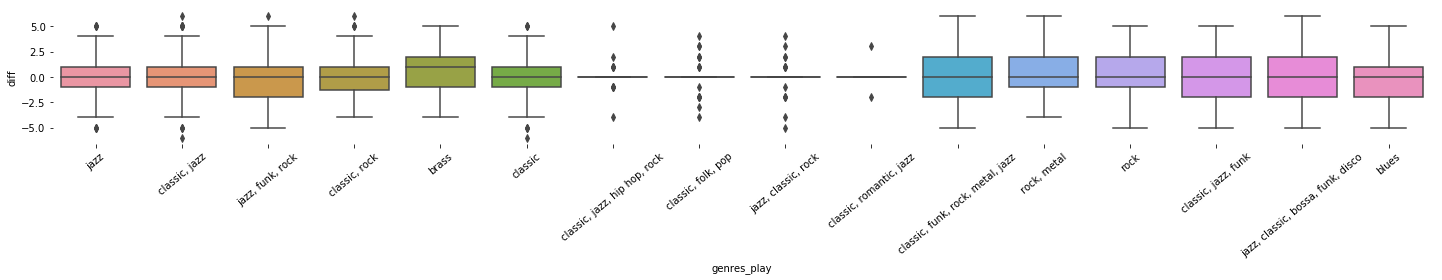

In [25]:
plt.figure(figsize=(30,30))
sns.factorplot(x = 'genres_play', y= 'diff', data = merged_df, kind = 'box', aspect =5)
plt.xticks(rotation=40)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('fig8.png', dpi = 400)


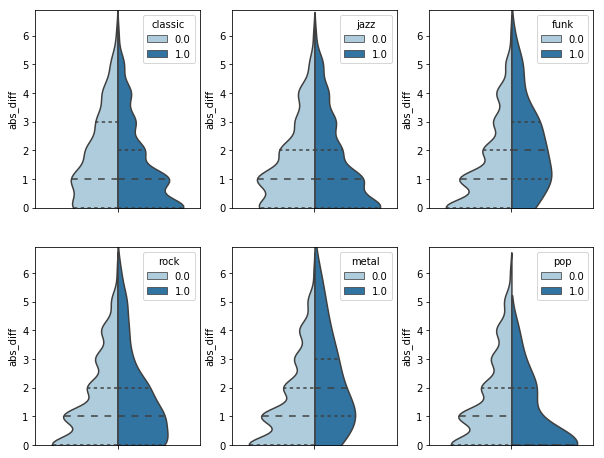

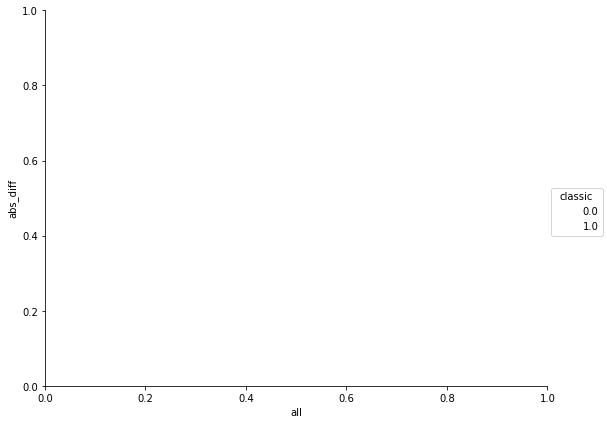

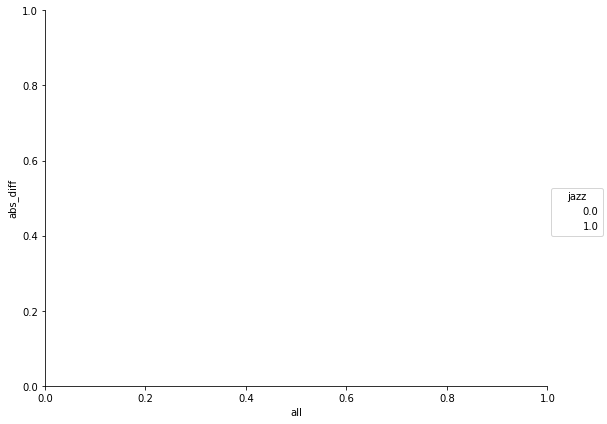

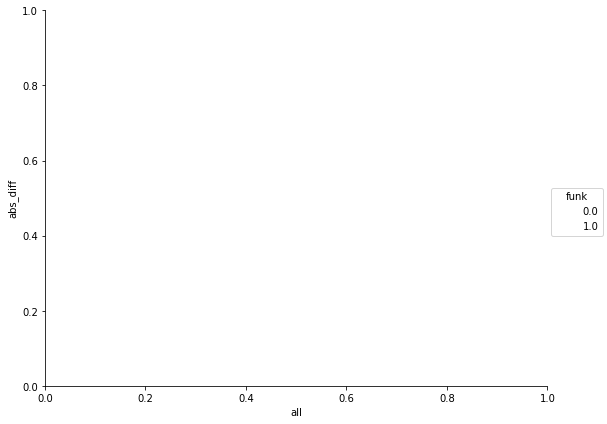

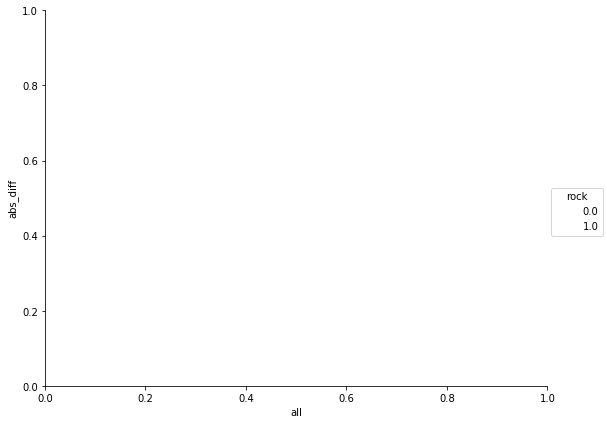

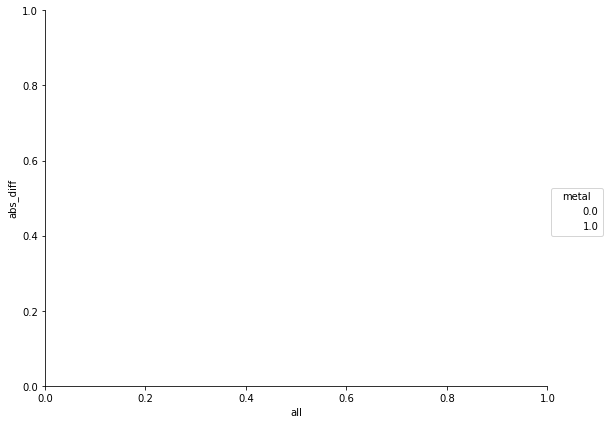

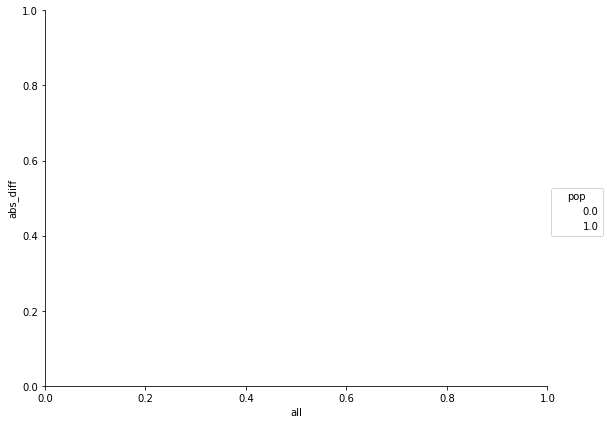

In [176]:
#sns.violinplot(x=['solo', 'band'], y='diff', hue = 'family_ap', data = merged_df, split = True)
fig9 = plt.figure(figsize=(10,8))
ax1 = fig9.add_subplot(231)
ax2 = fig9.add_subplot(232)
ax3 = fig9.add_subplot(233)
ax4 = fig9.add_subplot(234)
ax5 = fig9.add_subplot(235)
ax6 = fig9.add_subplot(236)

sns.factorplot(x = 'all', y ='abs_diff', hue = 'classic', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax1, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'jazz', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax2, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'funk', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax3, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'rock', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax4, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'metal', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax5, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff',hue = 'pop', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax6, split = True, inner = 'quart')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')

ax1.set_ylim(0,6.9)
ax2.set_ylim(0,6.9)
ax3.set_ylim(0,6.9)
ax4.set_ylim(0,6.9)
ax5.set_ylim(0,6.9)
ax6.set_ylim(0,6.9)


"""
ax1.set_ylabel('difference')
ax2.set_ylabel('difference')
ax3.set_ylabel('difference')
ax4.set_ylabel('difference')

ax2.set_ylim(-6.9,6.9)
ax4.set_ylim(-6.9,6.9)
"""
fig9.savefig('fig9.png', dpi = 400)




In [27]:
merged_df.columns


Index([               u'ID',            u'timbre',       u'heard_pitch',
          u'answered_pitch',              u'diff',          u'abs_diff',
         u'instr_principal',         u'instr_sec',               u'age',
           u'estimated_cap',            u'age_ap',         u'family_ap',
       u'age_music_studies',       u'rate_theory',    u'rate_technique',
               u'rate_hear',       u'genres_play',     u'genres_listen',
                 u'classic',              u'jazz',              u'funk',
                     u'pop',              u'rock',             u'metal',
                   u'other',              u'solo',              u'band',
                u'ensemble',         u'orchestra',        u'band_other',
                  u'scores',     u'chords + tabs',       u'improvising',
                 u'hearing',          u'by heart',           u'other.1',
             u'instr_class',   u'instr_sec_class',       u'instr_quant',
         u'instr_sec_quant',               u'all'],

In [127]:
#merged_df[merged_df.jazz == 1]

In [149]:
serie = merged_df[['age','age_music_studies']]

serie['age_music_studies'] = serie['age_music_studies'].replace('older than 16', 16)
serie['age_tot'] = serie['age'] - serie['age_music_studies']
serie['age_tot'].mean()

/Users/Albane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Albane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


15.533538936006169

In [160]:
merged_df.columns


Index([               u'ID',            u'timbre',       u'heard_pitch',
          u'answered_pitch',              u'diff',          u'abs_diff',
         u'instr_principal',         u'instr_sec',               u'age',
           u'estimated_cap',            u'age_ap',         u'family_ap',
       u'age_music_studies',       u'rate_theory',    u'rate_technique',
               u'rate_hear',       u'genres_play',     u'genres_listen',
                 u'classic',              u'jazz',              u'funk',
                     u'pop',              u'rock',             u'metal',
                   u'other',              u'solo',              u'band',
                u'ensemble',         u'orchestra',        u'band_other',
                  u'scores',     u'chords + tabs',       u'improvising',
                 u'hearing',          u'by heart',           u'other.1',
             u'instr_class',   u'instr_sec_class',       u'instr_quant',
         u'instr_sec_quant',               u'all'],

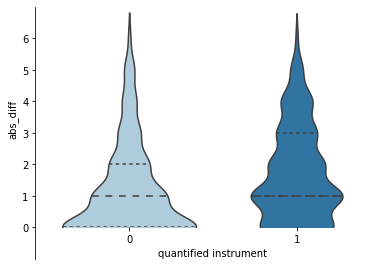

In [172]:
sns.violinplot(x = 'instr_quant', y = 'abs_diff', data=merged_df, palette ='Paired', inner = 'quart')
sns.despine(offset=10, trim=True, bottom = True)
plt.ylim(0,6.9)
plt.xlabel('quantified instrument')
plt.savefig('fig10.png', dpi = 400)

In [171]:
merged_df.groupby('instr_quant')['abs_diff'].describe()



,count,mean,std,min,25%,50%,75%,max
instr_quant,,,,,,,,
0,527.0,1.132827,1.428061,0.0,0.0,1.0,2.0,6.0
1,727.0,1.705640,1.478499,0.0,1.0,1.0,3.0,6.0
